# I. Data Preprocessing

In [1]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark) # relative? 

landmarks = np.array(landmarks).astype('float32')
bboxes = np.array(bboxes).astype('float32') 

In [2]:
# build a dataset
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import numpy
import cv2
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

/home/it/miniforge3/envs/180/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class IbugTrainingHeatmapDataset(Dataset):
    def __init__(self, img_filenames, bboxes, landmarks, normalize=True, albu_transform=None, sigma=1):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.landmarks = landmarks
        self.albu_transform = albu_transform # albumentations
        self.normalize = normalize
        self.sigma = sigma
        if not self.normalize:
            print('Not normalizing the image')
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        landmark_ori = self.landmarks[idx] # (68, 2)
        
        x, y, w, h = bounding_box # left, top, width, height
        # some landmarks are out of the bounding box! how to deal with this?
        x_center = x + w / 2
        y_center = y + h / 2
        w1 = 1.3 * w
        h1 = 1.3 * h
        x = x_center - w1 / 2
        y = y_center - h1 / 2
        w = w1
        h = h1
        # x should be in [0, W], y should be in [0, H]
        x = max(0, x)
        y = max(0, y)
        x = min(x, opened_img.width - 1)
        y = min(y, opened_img.height - 1)
        w = min(w, opened_img.width - x)
        h = min(h, opened_img.height - y)
        
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h)) # shape (h, w, C)

        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255] # shape (H, W, C)

        # to grayscale
        cropped_by_bbox = cv2.cvtColor(cropped_by_bbox, cv2.COLOR_RGB2GRAY) # shape (H, W)
        # resize
        cropped_by_bbox = cv2.resize(cropped_by_bbox, (224, 224))

        landmark = np.zeros_like(landmark_ori)
        landmark[:, 0] = landmark_ori[:, 0] - x
        landmark[:, 1] = landmark_ori[:, 1] - y
        landmark = landmark / [w, h] # relative coordinates
        
        # assert np.all(landmark == landmark2)
        # print("h: ", h, "w: ", w, "x: ", x, "y: ", y)
        
        # to relative coordinates
        if self.albu_transform:
            transformed = self.albu_transform(image=cropped_by_bbox, keypoints=landmark * 224)
            tfed_im = transformed['image'] # 68 tokens and each token has 224*224 classes
            landmark = transformed['keypoints'] / 224.
        else:
            tfed_im = cropped_by_bbox
            
        if self.normalize:
            tfed_im = tfed_im / 255.0 - 0.5

        # heatmap should be (68, 224, 224)
        heatmap = self._gaussian_heatmap(landmark * 224, 224, 224, 68)
        heatmap = torch.tensor(heatmap)
        heatmap = heatmap.float()
        landmark = torch.tensor(landmark)
        return tfed_im, heatmap, landmark # tfed_im: (C=1, 224, 224), heatmap: (68, 224, 224), landmark: (68, 2)
    
    def _gaussian_heatmap(self, landmark, height, width, channels):
        heatmap = np.ones((channels, height, width)).astype(np.float32)
        # landmark: (68, 2)
        for i, (x, y) in enumerate(landmark):
            x_coords = np.arange(width) # from 0 to width-1
            y_coords = np.arange(height) # 68 tokens and each token has 224*224 classes
            x_coords, y_coords = np.meshgrid(x_coords, y_coords)
            heatmap[i] = np.exp(-((x_coords / 224. - x / 224.) ** 2 + (y_coords / 224. - y / 224.) ** 2) / (2 * self.sigma ** 2))
            # print("x: ", x, "y: ", y)
            # print("heatmap: ", heatmap[i])
            # optional: normalize the heatmap by max or sum
            # heatmap[i] = heatmap[i] / np.sum(heatmap[i])
        return heatmap

transform = A.Compose([
    A.Affine(rotate=(-15, 15), translate_percent={'x': 0.1, 'y': 0.1}),
    A.GaussNoise(p=0.5), # DO WE NEED THIS?
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

dataset = IbugTrainingHeatmapDataset(img_filenames, bboxes, landmarks, albu_transform=transform, normalize=True, sigma=.02)

In [4]:
from unet import heatmap_to_landmarks

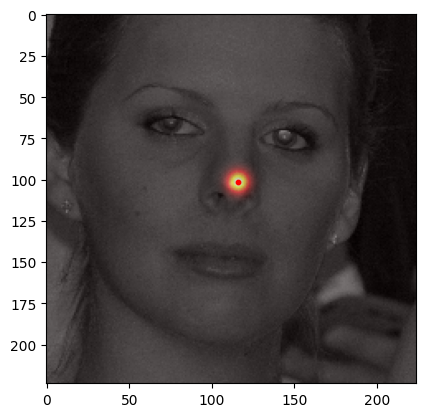

In [5]:
# visualize one heatmap
import matplotlib.pyplot as plt
tfed_im, heatmap, landmark = dataset[515]
# print(tfed_im)
plt.imshow(tfed_im.permute(1, 2, 0).squeeze(), cmap='gray')
# show heatmap
ii = 30
plt.imshow(heatmap[ii], cmap='hot', alpha=0.5)
# show landmark
plt.scatter(landmark[ii, 0] * 224, landmark[ii, 1] * 224, s=10, c='red')
plt.show()
# want to aggregate the heatmap to get the landmark
landmark_pred = heatmap_to_landmarks(heatmap.unsqueeze(0))

# II. Model Architecture
We use a UNet predicting the probability density heatmap (shape [68, 224, 224]) of the face landmarks, and then find the expected position of the landmarks w.r.t. the heatmap,
i.e. a pixelwise classification problem.

In [6]:
# unet
import torch
import torch.nn as nn
import torch.nn.functional as F
# load unet
from unet import PixelwiseClassificationUNet

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PixelwiseClassificationUNet(1, 68, 96).to(device)
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {n_params}')

Number of parameters: 4279940


# III. Training

In [8]:

from tqdm import tqdm
LR = 5e-4
BS = 16
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
num_epochs = 30
criterion = nn.MSELoss() # label is gaussian heatmap
mae = nn.L1Loss()
# criterion = nn.BCEWithLogitsLoss() # recommended for binary classification i.e. label is 0 or 1
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)])
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=16)

In [9]:
from unet import heatmap_to_landmarks

In [10]:
import warnings
warnings.filterwarnings("ignore")
# train
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mae = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
    for i, (images, heatmaps, landmark) in loop:
        # bad heatmap -> jump to next iteration
        # i.e. < 1e-4
        # if torch.sum(heatmaps) < 1e-4:
        #     continue
        images = images.to(device) # shape: (B, C, H, W)
        landmark = landmark.to(device) # shape: (B, 68, 2)
        heatmaps = heatmaps.to(device) # shape: (B, 68, H, W)
        
        # Forward pass
        logits = model.forward(images, return_heatmap=True) # shape: (B, 68, 224*224)
        # probs = F.softmax(logits, dim=2) # shape: (B, 68, 224*224)
        probs = F.sigmoid(logits)
        probs = probs.view(-1, 68, 224, 224)
        loss = criterion(probs, heatmaps)
        # learn the heatmap: not what we are doing now
        # pred_heatmap = model(images, return_heatmap=True) # shape: (B, 68, H*W)
        # do BCE
        # heatmaps = heatmaps.view(-1, 68, 224*224) # shape: (B, 68, H*W)
        # loss = bce(pred_heatmap, heatmaps)
        with torch.no_grad():
            predicted_landmark = heatmap_to_landmarks(probs) # shape: (B, 68, 2)
            mae_loss = mae(predicted_landmark, landmark * 224)
            train_mae += mae_loss.item()
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item(), mae=mae_loss.item())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_mae /= len(train_loader)
    # validation
    model.eval()
    val_loss = 0
    val_mae = 0
    loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
    loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
    with torch.no_grad():
        for i, (images, heatmaps, landmark) in loop:
            images = images.to(device) # shape: (B, C, H, W)
            heatmaps = heatmaps.to(device) # shape: (B, 68, H, W)
            landmark = landmark.to(device) # shape: (B, 68, 2)
            # Forward pass
            logits = model.forward(images, return_heatmap=True) # shape: (B, 68, 224*224)
            # probs = F.softmax(logits, dim=2) # shape: (B, 68, 224*224)
            
            probs = F.sigmoid(logits) # shape: (B, 68, 224*224)
            probs = probs.view(-1, 68, 224, 224)
            predicted_landmark = heatmap_to_landmarks(probs) # *224
            loss = criterion(probs, heatmaps) 
            mae_loss = mae(predicted_landmark, landmark * 224)
            val_mae += mae_loss.item()
            val_loss += loss.item()
            loop.set_postfix(val_loss=loss.item(), mae=mae_loss.item())
            
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train MAE: {train_mae}, Val MAE: {val_mae}')
        

Epoch [1/30]:   0%|          | 0/375 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 210.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 158.81 MiB is free. Including non-PyTorch memory, this process has 7.48 GiB memory in use. Of the allocated memory 7.06 GiB is allocated by PyTorch, and 279.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:


# %pip install pandas
import xml.etree.ElementTree as ET 
import numpy as np
import pandas as pd
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

bboxes = np.array(bboxes).astype('float32') 
print(bboxes.shape)
print(len(img_filenames))
print(img_filenames[0])

# we now have img_filenames and bboxes
# for every i in range(len(img_filenames)), 
# we crop the image, resize it to (224, 224), and then feed it to the model
# the output is the landmarks in shape (68, 2)
class IBugTestDataset(Dataset):
    def __init__(self, img_filenames, bboxes, normalize=True, basic_transform=None):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.basic_transform = basic_transform # resize, totensor
        self.normalize = normalize
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        # grayscale
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        x, y, w, h = bounding_box # left, top, width, height
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h))
        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255]
        if self.normalize:
            cropped_by_bbox = cropped_by_bbox / 255.0 - 0.5
            
        if self.basic_transform:
            cropped_by_bbox = self.basic_transform(cropped_by_bbox)
        else:
            cropped_by_bbox = torch.tensor(cropped_by_bbox).permute(2, 0, 1) # (C, H, W)
        return cropped_by_bbox, bounding_box
    
basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # From (C, H, W) to (C, 224, 224)
    # grayscale
    transforms.Grayscale(num_output_channels=1), # From (C, H, W) to (1, H, W)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = IBugTestDataset(img_filenames, bboxes, basic_transform=basic_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False)

# test
model.eval()
preds = []
with torch.no_grad():
    for (images, bbox) in tqdm(test_loader):
        images = images.to(device)
        logits = model(images) # [0, 1] # shape: (B, 68, 224*224)
        probs = F.sigmoid(logits) # shape: (B, 68, 224*224)
        probs = probs.view(-1, 68, 224, 224)
        predicted_landmarks = heatmap_to_landmarks(probs) # shape: (B, 68, 2)
        x, y, w, h = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
        # to devices
        x, y, w, h = x.to(device), y.to(device), w.to(device), h.to(device)
        # adjust the landmark
        predicted_landmarks[:, :, 0] = predicted_landmarks[:, :, 0] * w[:, None] + x[:, None]
        predicted_landmarks[:, :, 1] = predicted_landmarks[:, :, 1] * h[:, None] + y[:, None]
        preds.append(predicted_landmarks)
preds = torch.cat(preds, dim=0) # (N, 68, 2)
# preds = preds.cpu().numpy()
# preds = preds.tolist()



In [ ]:
alternating_names = [] # should be 136 * test_size(1008) = 137088
alternating_values = []
counter = 0
for i in range(len(preds)):
    pred = preds[i] # (68, 2)
    # to list
    pred = pred.cpu().numpy().tolist()
    
    for j in range(68):
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_x')
        alternating_names.append(str(counter))
        counter += 1
        alternating_names.append(str(counter))
        counter += 1
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_y')
        
        alternating_values.append(pred[j][0]) # x
        alternating_values.append(pred[j][1]) # y
        
        
        
df = pd.DataFrame({'Id': alternating_names, 'Predicted': alternating_values})

os.makedirs('4', exist_ok=True)
df.to_csv('4/submission.csv', index=False)
!cd 4 && ls -l && kaggle competitions submit -c cs194-26-fall-2022-project-5 -f submission.csv -m "UNet, 30 epochs, 1e-3 LR, 16 BS, 64 hidden channels"
